In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn

import utils
import aug_functions
import single_layer_aug

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
data = pd.read_csv('../data/plasticc/good_objects.csv', index_col=0)

data = data[data.detected == 1]
data.head()

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
222,13,60532.3019,2,24.529644,1.046373,1,3.790512,0
223,13,60532.3097,1,23.404964,0.992504,1,3.675929,0
224,13,60532.3173,3,36.069386,1.568371,1,3.875155,0
225,13,60532.3282,4,42.765503,2.305008,1,3.938479,0
226,13,60532.3392,5,36.567162,5.439748,1,3.987288,0


In [4]:
object_ids = np.unique(data.object_id)

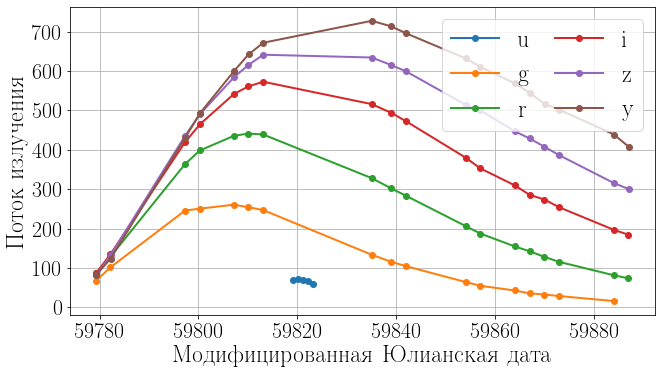

In [5]:
anobject = aug_functions.get_object(data, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
# train / test split
from sklearn.model_selection import train_test_split
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

X_train = anobject_train[['mjd', 'log_lam']].values
X_test = anobject_test[['mjd', 'log_lam']].values

y_train = anobject_train['flux'].values
y_test  = anobject_test['flux'].values

from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
X_train_ss = ss_x.fit_transform(X_train)
X_test_ss = ss_x.transform(X_test)

ss_y = StandardScaler()
y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))
y_test_ss = ss_y.transform(y_test.reshape((-1, 1)))

reg = single_layer_aug.FitNNRegressor(n_hidden=80, n_epochs=100, batch_size=1, optimizer='SGD', lr=0.01)
reg.fit(X_train_ss, y_train_ss)

# predict flux for unseen observations
anobject_test_pred = anobject_test.copy()
res = ss_y.inverse_transform(reg.predict(X_test_ss))
anobject_test_pred['flux'] = np.maximum(res, np.zeros(res.shape))

# predict flux for known observations
anobject_train_pred = anobject_train.copy()
res = ss_y.inverse_transform(reg.predict(X_train_ss))
anobject_train_pred['flux'] = np.maximum(res, np.zeros(res.shape))

# calculate quality metrics
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                                      anobject_test_pred['flux'])
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  9.590412916750644
MAE:  7.188971146477192
RSE:  0.04559083112673475
RAE:  0.038385744044639396
MAPE:  6.242385427698295


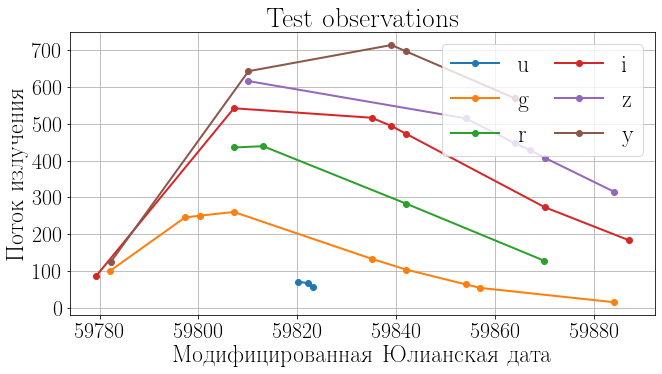

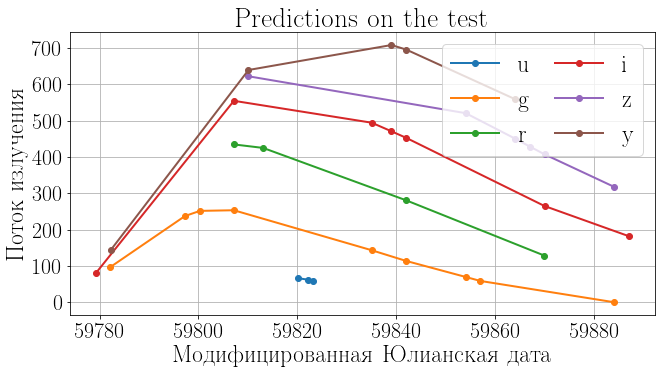

In [7]:
aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

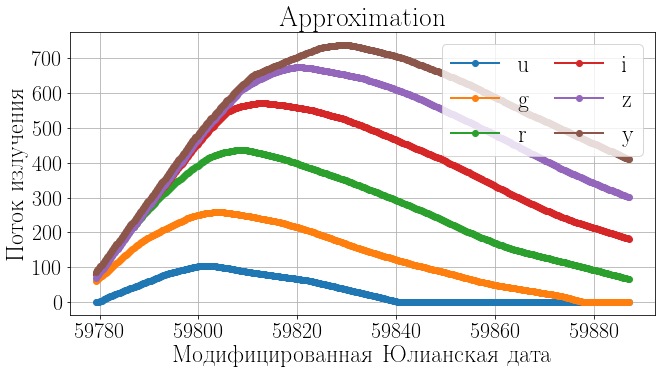

In [8]:
approx_object = aug_functions.create_approx_object(anobject)
X = approx_object[['mjd', 'log_lam']].values

X_ss = ss_x.transform(X)
res = ss_y.inverse_transform(reg.predict(X_ss))
approx_object['flux'] = np.maximum(res, np.zeros(res.shape))
aug_functions.plot_light_curves(approx_object, "Approximation")

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

In [11]:
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler

def test_model(n_hidden=10, n_epochs=100, batch_size=1, lr=0.01, optimizer='SGD'):
    metrics = []
    index = np.random.choice(len(object_ids), size=len(object_ids) // 5)
    for i in index:
        good_id = object_ids[i]

        # get an object
        anobject = aug_functions.get_object(data, good_id)

        # train / test split
        anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

        X_train = anobject_train[['mjd', 'log_lam']].values
        X_test  = anobject_test[['mjd', 'log_lam']].values

        y_train = anobject_train['flux'].values
        y_test  = anobject_test['flux'].values

        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train)
        X_test_ss = ss.transform(X_test)

        ss_y = StandardScaler()
        y_train_ss = ss_y.fit_transform(y_train.reshape((-1, 1)))

        # fit a regression model to approximate light curves
        reg = single_layer_aug.FitNNRegressor(n_hidden=n_hidden, 
                                              n_epochs=n_epochs, 
                                              batch_size=batch_size, 
                                              lr=lr, 
                                              optimizer=optimizer)
        reg.fit(X_train_ss, y_train_ss)

        # predict flux for unseen observations
        anobject_test_pred = anobject_test.copy()
        y_pred = ss_y.inverse_transform(reg.predict(X_test_ss))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        metrics.append(mape)

    return np.mean(metrics)

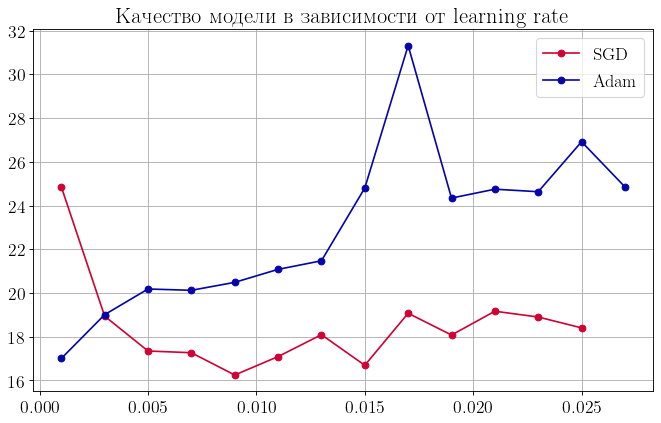

In [12]:
learning_rate = np.arange(0.001, 0.03, 0.002)
sgd_metrics = []
adam_metrics = []
sgd_lr = []
adam_lr = []

for lr in tqdm_notebook(learning_rate):
    try:
        sgd_mape = test_model(n_hidden=125, n_epochs=250, optimizer='SGD', lr=lr)
        sgd_metrics.append(sgd_mape)
        sgd_lr.append(lr)

        adam_mape = test_model(n_hidden=100, n_epochs=250, optimizer='Adam', lr=lr)
        adam_metrics.append(adam_mape)
        adam_lr.append(lr)
    except:
        continue
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от learning rate", fontsize=20)
plt.plot(sgd_lr, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(adam_lr, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_lr_one_layer.pdf")    

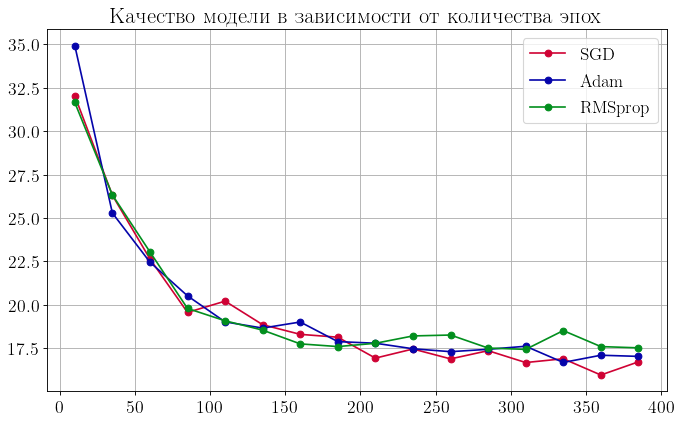

In [13]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

epochs_range = np.arange(10, 401, 25)
for epochs in tqdm_notebook(epochs_range):
    adam_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='Adam', lr=0.001)
    adam_metrics.append(adam_mape)
    sgd_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='SGD')
    sgd_metrics.append(sgd_mape)
    RMSprop_mape = test_model(n_hidden=100, n_epochs=epochs, optimizer='RMSprop', lr=0.001)
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества эпох", fontsize=20)
plt.grid(True)
plt.plot(epochs_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(epochs_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(epochs_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nepochs_one_layer.pdf")

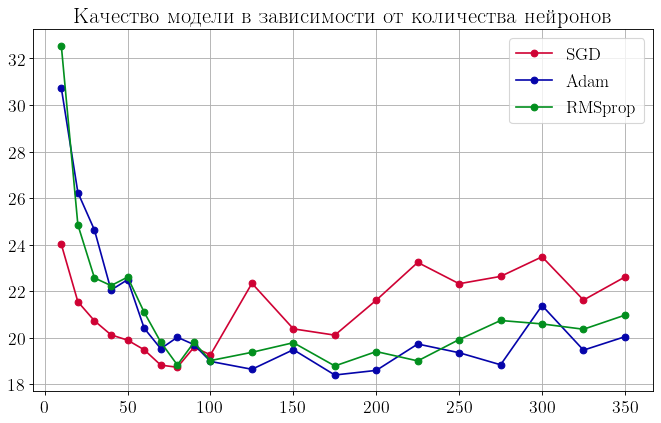

In [14]:
sgd_metrics = []
adam_metrics = []
RMSprop_metrics = []

neurons_range = np.concatenate((np.arange(10, 100, 10), np.arange(100, 351, 25)))
for n_hidden in tqdm_notebook(neurons_range):
    sgd_mape = test_model(n_hidden, optimizer='SGD')
    sgd_metrics.append(sgd_mape)
    adam_mape = test_model(n_hidden, optimizer='Adam', lr=0.001)
    adam_metrics.append(adam_mape)
    RMSprop_mape = test_model(n_hidden, optimizer='RMSprop', lr=0.001)
    RMSprop_metrics.append(RMSprop_mape)
    
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("Качество модели в зависимости от количества нейронов", fontsize=20)
plt.plot(neurons_range, sgd_metrics, "-o", color="xkcd:cherry", label="SGD")
plt.plot(neurons_range, adam_metrics, "-o", color="xkcd:royal blue", label="Adam")
plt.plot(neurons_range, RMSprop_metrics, "-o", color="xkcd:emerald green", label="RMSprop")
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()
fig.savefig("../pictures/metrics_nhidden_one_layer.pdf")

In [15]:
anobject = aug_functions.get_object(data, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err = model.predict(anobject_test['mjd'].values, 
                                    anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

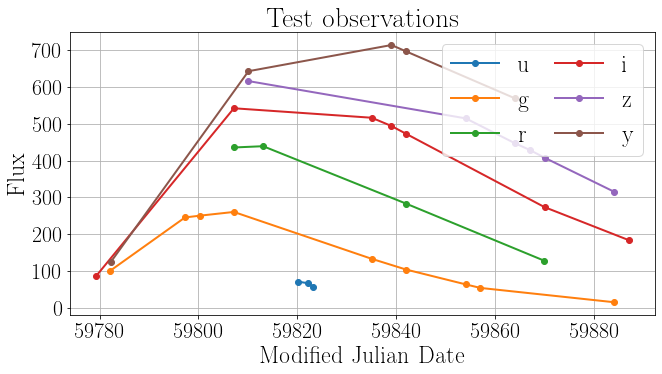

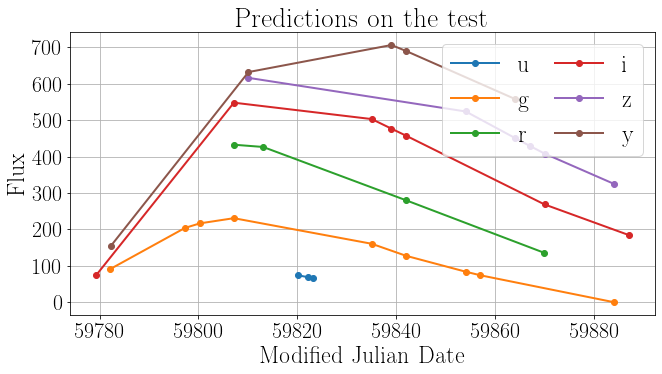

In [16]:
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)

aug_functions.plot_light_curves(anobject_test, "Test observations")
aug_functions.plot_light_curves(anobject_test_pred, "Predictions on the test")

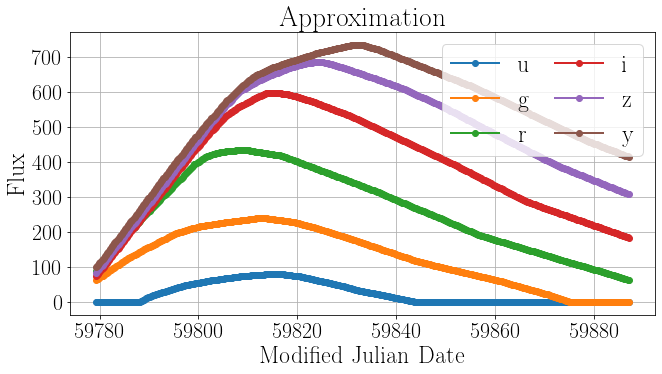

In [17]:
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [10]:
from tqdm import tqdm
from tqdm import tqdm_notebook

metrics = []
for good_id in tqdm_notebook(object_ids):
    # get an object
    anobject = aug_functions.get_object(data, good_id)

    # train / test split
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)
    
    # fit augmentation model
    model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # calc metrics
    metrics.append(utils.regression_quality_metrics_report(anobject_test['flux'].values, 
                                                           flux_pred.reshape((1, -1))[0]))

df_metrics = pd.DataFrame(data=metrics, columns=["RMSE", "MAE", "RSE", "RAE", "MAPE"])
df_metrics.mean()

  0%|          | 0/2508 [00:00<?, ?it/s]

RMSE    28.830991
MAE     17.679996
RSE      0.370479
RAE      0.327096
MAPE    21.969356
dtype: float64

In [11]:
rmse = np.array(metrics)[:,0]
mae = np.array(metrics)[:,1]
rse = np.array(metrics)[:,2]
rae = np.array(metrics)[:,3]
mape = np.array(metrics)[:,4]

N = len(object_ids)
assert len(rmse) == N
assert len(mae) == N
assert len(rse) == N
assert len(rae) == N
assert len(mape) == N

sample_coeffs = np.random.randint(0, N, (10000, 1000))
sample_rmse = rmse[sample_coeffs]
sample_rmse_mean = sample_rmse.mean(axis=1)
print("RMSE: mean = %.4f, std = %.4f" % (sample_rmse_mean.mean(), sample_rmse_mean.std()))
sample_mae = mae[sample_coeffs]
sample_mae_mean = sample_mae.mean(axis=1)
print("MAE:  mean = %.4f, std = %.4f" % (sample_mae_mean.mean(), sample_mae_mean.std()))
sample_rse = rse[sample_coeffs]
sample_rse_mean = sample_rse.mean(axis=1)
print("RSE:  mean = %.4f,  std = %.4f" % (sample_rse_mean.mean(), sample_rse_mean.std()))
sample_rae = rae[sample_coeffs]
sample_rae_mean = sample_rae.mean(axis=1)
print("RAE:  mean = %.4f,  std = %.4f" % (sample_rae_mean.mean(), sample_rae_mean.std()))
sample_mape = mape[sample_coeffs]
sample_mape_mean = sample_mape.mean(axis=1)
print("MAPE: mean = %.4f, std = %.4f" % (sample_mape_mean.mean(), sample_mape_mean.std()))

RMSE: mean = 28.8595, std = 11.9594
MAE:  mean = 17.6886, std = 6.2310
RSE:  mean = 0.3705,  std = 0.0058
RAE:  mean = 0.3271,  std = 0.0049
MAPE: mean = 21.9715, std = 0.5234
